In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Handle data.
df = pd.read_csv('../data/20190624075954-20190624124954.csv')
df=df.replace([np.inf, -np.inf], np.nan)
df=df.dropna();
df=df.round(decimals=6)  # round to two decimals after precision of devices
df['diff'] = (df['B_VIMIN'] - df['B:VIMIN'])

# Taking the data we're focused on.
df2=pd.DataFrame({'time': df['time_B:VIMIN'],'diff' : df['diff'], 'err' : df['B:IMINER']})
df2=df2.set_index(pd.DatetimeIndex(df2['time'])) # set index to time (not in-place operation)

In [3]:
# FUNCTION: series_to_supervised
# INPUT: data   ~ numpy array of time series observations
#       n_lag   ~ number of lag observations as input 
#       n_out   ~ number of observations as output.
#       dropnan ~ Boolean whether or not to drop rows with NaN values.
# sourced: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_lag=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    col_data = []
    col_names = []
    # build the input sequence by concatenating farthest to closest in time
    for i in range(n_lag, 0, -1):
        col_data.append(df.shift(i))
        col_names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # build the output sequence
    for i in range(0, n_out):
        col_data.append(df.shift(-i))
        if i == 0:
            col_names += [('x%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            col_names += [('x%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(col_data, axis=1)
    agg.columns =col_names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
ts1 = np.array(df2['diff'].values)
ts1=ts1.reshape(-1,1)
#ts1 = normalize_data(ts1)
scaler = MinMaxScaler(feature_range=(0, 1))
ts1 = scaler.fit_transform(ts1)

data_sup = pd.DataFrame(series_to_supervised(ts1,10))

In [5]:
samp_freq = 15 # Hz
hr2sec = 3600 # convert hrs to seconds
p = 0.8 # percent of data to take
n_train = int(len(data_sup)* p)
train = data_sup.values[:n_train, :]
test = data_sup.values[n_train:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(205760, 1, 10) (205760,) (51441, 1, 10) (51441,)


In [6]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=10, batch_size=1000, validation_data=(x_test, y_test), verbose=2, shuffle=False)

W0625 15:27:12.916536  6788 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 15:27:12.976538  6788 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 15:27:12.994344  6788 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 15:27:13.379359  6788 deprecation_wrapper.py:118] From C:\Users\Rachael\.conda\envs\py3tf1gnt\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0625 15:27:13.607531  6

Train on 205760 samples, validate on 51441 samples
Epoch 1/10
 - 2s - loss: 0.0043 - val_loss: 1.0206e-04
Epoch 2/10
 - 1s - loss: 0.0035 - val_loss: 2.2231e-04
Epoch 3/10
 - 1s - loss: 0.0023 - val_loss: 2.5814e-04
Epoch 4/10
 - 1s - loss: 0.0012 - val_loss: 3.4098e-04
Epoch 5/10
 - 1s - loss: 0.0013 - val_loss: 5.8748e-05
Epoch 6/10
 - 1s - loss: 9.6831e-04 - val_loss: 8.2653e-05
Epoch 7/10
 - 1s - loss: 7.8509e-04 - val_loss: 1.4571e-04
Epoch 8/10
 - 1s - loss: 0.0013 - val_loss: 1.5013e-04
Epoch 9/10
 - 1s - loss: 4.8149e-04 - val_loss: 1.6647e-04
Epoch 10/10
 - 1s - loss: 9.8358e-04 - val_loss: 1.6360e-04


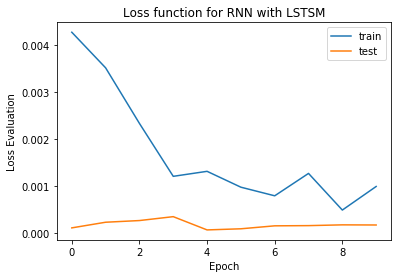

In [7]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss function for RNN with LSTSM")
plt.xlabel('Epoch')
plt.ylabel('Loss Evaluation')
plt.show()

In [8]:
# make a prediction
pred_window = 15;
yhat = model.predict(x_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[2]))

# transform back to original coordinates
inv_yhat = np.concatenate((yhat, x_test[:, -pred_window:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, x_test[:, -pred_window:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.019
